In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [3]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [4]:
import simdkalman

# define kf model
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

In [5]:
def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in tqdm(unique_paths):
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [6]:
def linear_interpolation(input_df, speed_thr=45):
    dfs = pd.DataFrame()
    for (collectionName, phoneName), df in input_df.groupby(['collectionName','phoneName']):

        df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
        df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
        df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
        df['speed'].fillna(0, inplace=True)

        # 一度欠損値にする
        df.loc[speed_thr<df['speed'], ['latDeg', 'lngDeg']] = np.nan
        df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
        df = df.set_index('dummy_datetime')

        # 時間に合わせて線形補間
        df = df.interpolate(method='time').reset_index(drop=True)
        dfs = pd.concat([dfs, df]).reset_index(drop=True)
    return dfs

In [7]:
# config
EXP_NAME = str(Path().resolve()).split('/')[-1]
EXP_NAME

'exp013'

In [8]:
# waypointを補正したdataset
root_dir = Path('../../input/google-smartphone-decimeter-challenge')

## LI -> KF  

In [9]:
import multiprocessing
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
calc_haversine(train_df['latDeg'],train_df['lngDeg'],train_df['target_latDeg'], train_df['target_lngDeg']).mean()

  0%|          | 0/73 [00:00<?, ?it/s]

3.8468483749952074

In [10]:
train_df = linear_interpolation(train_df)
calc_haversine(train_df['latDeg'],train_df['lngDeg'],train_df['target_latDeg'], train_df['target_lngDeg']).mean()

3.6010082912730264

In [11]:
train_df = apply_kf_smoothing(train_df)
calc_haversine(train_df['latDeg'],train_df['lngDeg'], train_df['target_latDeg'], train_df['target_lngDeg']).mean()

  0%|          | 0/73 [00:00<?, ?it/s]

3.152398745382418

In [12]:
# data womizumasi
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
 
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')

    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])

    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)


    # Leave only records to be interpolated(missing coords data)
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]

    return lerp_df[org_columns]


def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df


def apply_mean(df):
    lerp = make_lerp_data(df)
    mean_df = calc_mean_pred(df, lerp)
    return mean_df

In [13]:
train_df = apply_mean(train_df)

In [14]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
calc_haversine(train_df['latDeg'],train_df['lngDeg'], train_df['target_latDeg'], train_df['target_lngDeg']).mean()

  0%|          | 0/73 [00:00<?, ?it/s]

2.9059163056773833

In [15]:
import plotly.express as px

def visualize_trafic(df):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            text='phoneName',
                            
                            #Here, plotly detects color of series
                            color="collectionName",
                            labels="collectionName",
                            
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()


def visualize_collection(df, root_dir, collection_name='2021-04-29-US-SJC-2'):
    gt_df = pd.read_csv(root_dir / 'all_ground_truth.csv')
    gt_df['phoneName'] = 'ground truth'
    gt_df = pd.concat([df, gt_df])
    target_df = gt_df[gt_df['collectionName']==collection_name]   
    target_df['elapsed_epoch'] = ((target_df['millisSinceGpsEpoch'] - target_df['millisSinceGpsEpoch'].min()) / 1000).astype(str).to_numpy()
    fig = px.scatter_mapbox(target_df,
                                
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            text='elapsed_epoch',
                                
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                                
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="{collection_name}")
    fig.show()

In [16]:
collection_names = train_df["collectionName"].unique()
print((len(collection_names)))

29


In [17]:
# visualize_collection(train_df, root_dir=Path("../../input/"), collection_name=collection_names[28])

In [34]:
def snap_to_grid(sub, min_thr, max_thr):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_latDeg_'] = sub['latDeg']
    sub['_lngDeg_'] = sub['lngDeg']
    sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), '_latDeg_'] = sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), 'matched_latDeg']
    sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), '_lngDeg_'] = sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), 'matched_lngDeg']
    return sub.copy()

from scipy.spatial.distance import cdist

def add_xy(df):
    df['point'] = [(x, y) for x,y in zip(df['lngDeg'], df['latDeg'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

In [19]:
from shapely.geometry import Point
import osmnx as ox
import momepy

dfs = []
for collection_name, coll_df in train_df.groupby("collectionName"):
    if collection_name != collection_names[28]:
        continue

    buffer = 0.1**6
    north = coll_df["latDeg"].max() + buffer
    south = coll_df["latDeg"].min() - buffer
    east = coll_df["lngDeg"].max() - buffer
    west = coll_df["lngDeg"].min() + buffer
    G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
    nodes, edges = momepy.nx_to_gdf(G)
    edges = edges.dropna(subset=["geometry"])

    lat_list = []
    lng_list = []
    for i, row in edges.iterrows():
        points = row["geometry"].coords[:]
        lat_list += [p[1] for p in points]
        lng_list += [p[0] for p in points]
    load_points = pd.DataFrame([lat_list, lng_list], index=["latDeg", "lngDeg"]).T

    coll_df = add_xy(coll_df)
    load_points = add_xy(load_points)

    coll_df['matched_point'] = [closest_point(p, list(load_points['point'])) for p in coll_df['point']]
    coll_df['matched_lngDeg'] = coll_df['matched_point'].apply(lambda x: x[0])
    coll_df['matched_latDeg'] = coll_df['matched_point'].apply(lambda x: x[1])

    dfs.append(coll_df)

/home/user/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/momepy/utils.py:418: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


In [23]:
snap_df = pd.concat(dfs).sort_index().reset_index(drop=True)
snap_df['dist'] = calc_haversine(snap_df["latDeg"], snap_df["lngDeg"], snap_df["matched_latDeg"], snap_df["matched_lngDeg"])

<AxesSubplot:>

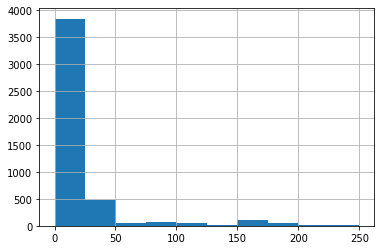

In [24]:
snap_df["dist"].hist()

In [ ]:
snap_to_grid(snap_df, min_thr=0, max_thr=0)

<AxesSubplot:>

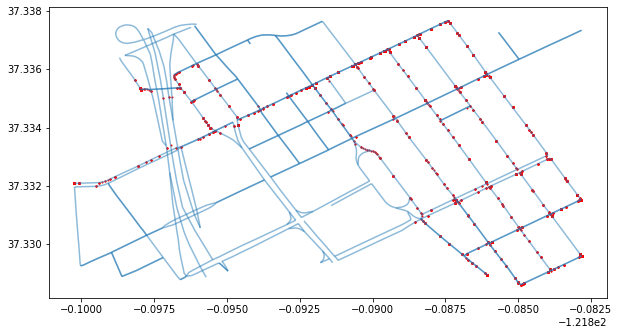

In [27]:
import geopandas as gpd

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
edges.plot(ax=ax, alpha=0.5)
tmp1 = snap_df.copy()
tmp1["geometry"] = [Point(p) for p in snap_df["matched_point"].to_numpy()]
tmp1 = gpd.GeoDataFrame(tmp1, geometry=tmp1["geometry"])
tmp1.plot(ax=ax, markersize=1, color="red")

tmp2 = snap_df.copy()
tmp2["geometry"] = [Point(p) for p in snap_df["point"].to_numpy()]
tmp2 = gpd.GeoDataFrame(tmp2, geometry=tmp2["geometry"])
tmp2.plot(ax=ax, markersize=1, color="green")


In [28]:
calc_haversine(snap_df["latDeg"], snap_df["lngDeg"], snap_df["target_latDeg"], snap_df["target_lngDeg"]).mean()

7.4295116036361275

In [45]:
snap_df = snap_to_grid(snap_df, min_thr=14, max_thr=15)
calc_haversine(snap_df["_latDeg_"], snap_df["_lngDeg_"], snap_df["target_latDeg"], snap_df["target_lngDeg"]).mean()

7.70980046413295

In [45]:
fig = px.scatter_mapbox(snap_df,                              
                        # Here, plotly gets, (x,y) coordinates
                        lat="latDeg",
                        lon="lngDeg",
                        # text='elapsed_epoch',
                            
                        #Here, plotly detects color of series
                        color="phoneName",
                        labels="phoneName",
                            
                        zoom=9,
                        center={"lat":37.423576, "lon":-122.094132},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.update_layout(title_text="{collection_name}")
fig.show()

In [ ]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

## test

In [22]:
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv')

In [23]:
test_df = linear_interpolation(test_df)
test_df = apply_kf_smoothing(test_df)

  0%|          | 0/48 [00:00<?, ?it/s]

In [25]:
test_lerp = make_lerp_data(test_df)
test_df = calc_mean_pred(test_df, test_lerp)

In [26]:
test_df['phone'] = test_df['collectionName'] + "_" + test_df['phoneName']
test_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,phone
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416586,-122.082022,2020-05-15-US-MTV-1_Pixel4
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416597,-122.082043,2020-05-15-US-MTV-1_Pixel4
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416602,-122.082056,2020-05-15-US-MTV-1_Pixel4
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416603,-122.082064,2020-05-15-US-MTV-1_Pixel4
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416605,-122.082067,2020-05-15-US-MTV-1_Pixel4
...,...,...,...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000,37.334542,-121.899389,2021-04-29-US-SJC-3_SamsungS20Ultra
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000,37.334544,-121.899381,2021-04-29-US-SJC-3_SamsungS20Ultra
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000,37.334546,-121.899373,2021-04-29-US-SJC-3_SamsungS20Ultra
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000,37.334550,-121.899365,2021-04-29-US-SJC-3_SamsungS20Ultra


In [27]:
sub_df = sub_df.drop(['latDeg', 'lngDeg'], axis=1).merge(test_df[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['phone', 'millisSinceGpsEpoch'])
sub_df.to_csv('submission.csv', index=False)

In [28]:
sub_df

,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416586,-122.082022
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416597,-122.082043
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416602,-122.082056
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416603,-122.082064
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416605,-122.082067
...,...,...,...,...
91481,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763185000,37.334542,-121.899389
91482,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763186000,37.334544,-121.899381
91483,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763187000,37.334546,-121.899373
91484,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763188000,37.334550,-121.899365


In [29]:
_sub_df = pd.read_csv('../exp002/submission.csv')

In [30]:
calc_haversine(sub_df['latDeg'],sub_df['lngDeg'],
               _sub_df['latDeg'], _sub_df['lngDeg']).mean()

0.9691749925969024